In [1]:
import pandas as pd
from functools import partial
import numpy as np
from multiprocessing import Pool
import os
import matplotlib.pyplot as plt


class miDataFrame():

    def __init__(self,url=[],n_cores=1,emisiones=pd.DataFrame):
        self.url = url
        self.n_cores = n_cores
        self.emisiones = emisiones
        self.contadorFiltro = 0
        self.contadorReestructurar = 0
        self.tryfechas = 0
        self.dropvalidador=0
        # Códigos de las magnitudes contaminantes medidas
        self.magnitudes = {
            '1':'Dióxido de Azufre',
            '6':'Monóxido de Carbono',
            '7':'Monóxido de Nitrógeno',
            '8':'Dióxido de Nitrógeno',
            '9':'Partículas < 2.5 μm',
            '10':'Partículas < 10 μm',
            '12':'Óxidos de Nitrógeno',
            '14':'Ozono',
            '20':'Tolueno',
            '30':'Benceno',
            '35':'Etilbenceno',
            '37':'Metaxileno',
            '38':'Paraxileno',
            '39':'Ortoxileno',
            '42':'Hidrocarburos totales(hexano)',
            '43':'Metano',
            '44':'Hidrocarburosno metánicos (hexano)'
        }

        # Códigos de las estaciones de medición.
        self.estaciones = {
            '1':'Pº. Recoletos',
            '2':'Glta. de Carlos V',
            '35':'Pza. del Carmen',
            '4':'Pza. de España',
            '39':'Barrio del Pilar',
            '6':'Pza. Dr. Marañón',
            '7':'Pza. M. de Salamanca',
            '8':'Escuelas Aguirre',
            '9':'Pza. Luca de Tena',
            '38':'Cuatro Caminos',
            '11':'Av. Ramón y Cajal',
            '12':'Pza. Manuel Becerra',
            '40':'Vallecas',
            '14':'Pza. Fdez. Ladreda',
            '15':'Pza. Castilla',
            '16':'Arturo Soria', 
            '17':'Villaverde Alto',
            '18':'Calle Farolillo',
            '19':'Huerta Castañeda',
            '36':'Moratalaz',
            '21':'Pza. Cristo Rey',
            '22':'Pº. Pontones',
            '23':'Final C/ Alcalá',
            '24':'Casa de Campo',
            '25':'Santa Eugenia',
            '26':'Urb. Embajada (Barajas)',
            '27':'Barajas',
            '47':'Méndez Álvaro',
            '48':'Pº. Castellana',
            '49':'Retiro',
            '50':'Pza. Castilla',
            '54':'Ensanche Vallecas',
            '55':'Urb. Embajada (Barajas)',
            '56':'Plaza Elíptica',
            '57':'Sanchinarro',
            '58':'El Pardo',
            '59':'Parque Juan Carlos I',
            '60':'Tres Olivos'
        }
    def mapcontaminantes(self,x):
        if(isinstance(x,int)):
            return self.magnitudes.get(str(x),"Error de entrada")
        elif(isinstance(x,str)):
            return self.magnitudes.get(x,"Error de entrada")

    def generarDF(self):
        pool = Pool(self.n_cores)
        self.emisiones = pd.concat(pool.map(partial(pd.read_csv, sep=';'),self.url))

    def filtrarDataFrame(self):
        if(self.contadorFiltro ==0):
            def genListaFilt():
                r=range(1,32)
                return list(map(lambda x: f'V0{x}' if x<10 else f'V{x}',r))+['PUNTO_MUESTREO']
            self.emisiones = self.emisiones.iloc[:,2:]
            self.emisiones.drop(genListaFilt(), axis='columns', inplace=True)
            self.contadorFiltro +=1
        else:
            print("No puedes filtrar nuevamente.")

    def reestructurarDF(self):
        if(self.contadorReestructurar==0):
            self.emisiones = self.emisiones.melt(id_vars=['ESTACION', 'MAGNITUD', 'ANO', 'MES'], 
                                                var_name='DIA', value_name='VALOR')
            self.contadorReestructurar+=1
        else:
             print("Ya esta en el formato correcto.")

    def agregarFecha(self):
        if(self.tryfechas==0):
            self.emisiones['DIA'] = self.emisiones.DIA.str.strip('D')
            self.emisiones['FECHA'] = self.emisiones.ANO.apply(str) + '/' + self.emisiones.MES.apply(str) + '/' + self.emisiones.DIA.apply(str)
            self.emisiones['FECHA'] = pd.to_datetime(self.emisiones.FECHA, format='%Y/%m/%d', infer_datetime_format=True, errors='coerce')
            self.tryfechas+=1
        else:
             print("Ya tienes el formato de fechas creado.")
        
    
    def delNotValid(self):
        if(self.dropvalidador==0):
            print("Estoy Eliminando valores no validos.\n")
            self.emisiones = self.emisiones.drop(self.emisiones[np.isnat(self.emisiones.FECHA)].index)
            self.emisiones.sort_values(['ESTACION', 'MAGNITUD', 'FECHA'])
            self.dropvalidador+=1
        else:
            print("Ya se eliminaron los valores no validos.")


    def mostrarEstMag(self):
        print('Estaciones:', self.emisiones.ESTACION.unique())
        print('Contaminantes:', self.emisiones.MAGNITUD.unique())

    def mostrarDescriptivoContaminante(self):
        print(self.emisiones.groupby('MAGNITUD').VALOR.describe())

    def mostrarDescritivoContaminanteDistrito(self):
        #df_temp = self.emisiones.groupby(['ESTACION', 'MAGNITUD']).VALOR.describe()
        print(self.emisiones.groupby(['ESTACION', 'MAGNITUD']).VALOR.describe())

    def evolucion_mensual(self,cont, año):
        print(self.emisiones[(self.emisiones.MAGNITUD == cont) & 
                             (self.emisiones.ANO == año)]
              .groupby(['ESTACION', 'MES']).VALOR.mean().unstack('MES'))

    def evolucion_diaria(self,estacion, mes):
        print(self.emisiones[(self.emisiones.ESTACION == estacion) & 
                             (self.emisiones.MES == mes)].groupby(['MAGNITUD', 'DIA'])
                             .VALOR.mean().unstack('DIA'))

    #------Crear una función que reciba un rango de fechas y una magnitud y genere un gráfico con la evolución diaria de la magnitud para cada estación de medición en las fechas indicadas.
    def evolucionMagnitudRange(self,magnitud, desde, hasta):
        #self.emisiones['NOMBRE ESTACION'] = self.emisiones['ESTACION'].apply(lambda x: self.emisiones.ESTACION[x])
        df1 = self.emisiones[(self.emisiones['MAGNITUD'] == magnitud) & 
                             (self.emisiones.FECHA >= desde) & 
                             (self.emisiones.FECHA <= hasta)]
        df1.reset_index(inplace=True)
        df1.set_index('FECHA', inplace = True)
        fig, ax = plt.subplots(figsize=(22,6))
        df1.groupby('ESTACION')['VALOR'].plot(legend = True)
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        plt.show();

    #-----
    def evolucionMagnitud(self,magnitud):
        if(isinstance(magnitud, str)):
            magnitud = int(magnitud)
        #cont = [ 1  6  7  8 12  9 10 14 20 30 35 42 43 44]
        #[i for i in cont if i ]
        df1 = self.emisiones[(self.emisiones['MAGNITUD'] == magnitud)]

        df1.set_index('FECHA', inplace = True)
        fig, ax = plt.subplots(figsize=(22,6))
        df1.groupby('ESTACION')['VALOR'].plot(legend = True)
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        plt.show();

# Crear Objeto

In [2]:
URL = ["/content/drive/MyDrive/CursoCapacitacion/proyectoIntegrador/emisiones-2016.csv",
       "/content/drive/MyDrive/CursoCapacitacion/proyectoIntegrador/emisiones-2017.csv",
       "/content/drive/MyDrive/CursoCapacitacion/proyectoIntegrador/emisiones-2018.csv",
       "/content/drive/MyDrive/CursoCapacitacion/proyectoIntegrador/emisiones-2019.csv"]
n_cores = os.cpu_count() - 1
miClase = miDataFrame(URL,n_cores)

# Generar un DataFrame con los datos de los cuatro ficheros.

In [3]:
miClase.generarDF()
miClase.emisiones.head()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,D01,V01,D02,...,D27,V27,D28,V28,D29,V29,D30,V30,D31,V31
0,28,79,4,1,28079004_1_38,2016,1,8.0,V,7.0,...,9.0,V,7.0,V,8.0,V,9.0,V,9.0,V
1,28,79,4,1,28079004_1_38,2016,2,12.0,V,13.0,...,7.0,V,8.0,V,9.0,V,0.0,N,0.0,N
2,28,79,4,1,28079004_1_38,2016,3,11.0,V,10.0,...,8.0,V,7.0,V,8.0,V,10.0,V,8.0,V
3,28,79,4,1,28079004_1_38,2016,4,8.0,V,9.0,...,9.0,V,8.0,V,8.0,V,8.0,V,0.0,N
4,28,79,4,1,28079004_1_38,2016,5,7.0,V,8.0,...,7.0,V,7.0,V,7.0,V,7.0,V,7.0,V


# Filtrar las columnas del DataFrame para quedarse con las columnas ESTACION, MAGNITUD, AÑO, MES y las correspondientes a los días D01, D02, etc.

In [4]:
miClase.filtrarDataFrame()
miClase.emisiones.head()

,ESTACION,MAGNITUD,ANO,MES,D01,D02,D03,D04,D05,D06,...,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31
0,4,1,2016,1,8.0,7.0,6.0,6.0,7.0,6.0,...,10.0,11.0,11.0,13.0,12.0,9.0,7.0,8.0,9.0,9.0
1,4,1,2016,2,12.0,13.0,9.0,9.0,11.0,9.0,...,11.0,10.0,9.0,8.0,7.0,7.0,8.0,9.0,0.0,0.0
2,4,1,2016,3,11.0,10.0,9.0,9.0,7.0,8.0,...,8.0,8.0,9.0,9.0,9.0,8.0,7.0,8.0,10.0,8.0
3,4,1,2016,4,8.0,9.0,9.0,8.0,8.0,9.0,...,8.0,8.0,8.0,8.0,9.0,9.0,8.0,8.0,8.0,0.0
4,4,1,2016,5,7.0,8.0,9.0,9.0,8.0,8.0,...,7.0,7.0,8.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0


# Reestructurar el DataFrame para que los valores de los contaminantes de las columnas de los días aparezcan en una única columna.

In [5]:
miClase.reestructurarDF()
#miClase.emisiones

# Añadir una columna con la fecha a partir de la concatenación del año, el mes y el día (usar el módulo datetime).

In [6]:
miClase.agregarFecha()
miClase.emisiones

,ESTACION,MAGNITUD,ANO,MES,DIA,VALOR,FECHA
0,4,1,2016,1,01,8.0,2016-01-01
1,4,1,2016,2,01,12.0,2016-02-01
2,4,1,2016,3,01,11.0,2016-03-01
3,4,1,2016,4,01,8.0,2016-04-01
4,4,1,2016,5,01,7.0,2016-05-01
...,...,...,...,...,...,...,...
225241,60,14,2019,8,31,98.0,2019-08-31
225242,60,14,2019,9,31,0.0,NaT
225243,60,14,2019,10,31,47.0,2019-10-31
225244,60,14,2019,11,31,0.0,NaT


# Eliminar las filas con fechas no válidas (utilizar la función isnat del módulo numpy) y ordenar el DataFrame por estaciones, contaminantes y fecha.

In [7]:
miClase.delNotValid()
miClase.emisiones

Estoy Eliminando valores no validos.



,ESTACION,MAGNITUD,ANO,MES,DIA,VALOR,FECHA
0,4,1,2016,1,01,8.0,2016-01-01
1,4,1,2016,2,01,12.0,2016-02-01
2,4,1,2016,3,01,11.0,2016-03-01
3,4,1,2016,4,01,8.0,2016-04-01
4,4,1,2016,5,01,7.0,2016-05-01
...,...,...,...,...,...,...,...
225238,60,14,2019,5,31,85.0,2019-05-31
225240,60,14,2019,7,31,92.0,2019-07-31
225241,60,14,2019,8,31,98.0,2019-08-31
225243,60,14,2019,10,31,47.0,2019-10-31


# Mostrar por pantalla las estaciones y los contaminantes disponibles en el DataFrame

In [8]:
miClase.mostrarEstMag()

Estaciones: [ 4  8 11 16 17 18 24 27 35 36 38 39 40 47 48 49 50 54 55 56 57 58 59 60]
Contaminantes: [ 1  6  7  8 12  9 10 14 20 30 35 42 43 44]


# Mostrar un resumen descriptivo (mímino, máximo, media, etc) para cada contaminante.

In [9]:
miClase.mostrarDescriptivoContaminante()

            count       mean         std   min    25%    50%    75%       max
MAGNITUD                                                                     
1         14610.0   7.428953    7.012504  0.00   4.00   7.00  10.00    610.00
6         14610.0   0.350233    0.215935  0.00   0.20   0.30   0.40     14.90
7         35064.0  20.446412  135.123509  0.00   4.00   9.00  23.00  24742.00
8         35064.0  37.677618   20.118050  0.00  22.00  35.00  50.00    148.00
9          8948.0  10.087729   10.643591  0.00   6.00   9.00  13.00    850.00
10        17897.0  18.772923   35.723619  0.00  10.00  16.00  24.00   4481.00
12        35064.0  67.959417   61.443940  0.00  29.00  48.00  84.00   1005.00
14        20454.0  49.941772   24.753120  0.00  31.00  52.00  69.00    336.00
20         8766.0   2.364944    4.236706  0.00   0.80   1.60   2.80    195.00
30         8766.0   0.531371    0.538180  0.00   0.20   0.40   0.70     15.10
35         8766.0   0.479751    1.183618  0.00   0.10   0.20   0

# Mostrar un resumen descriptivo para cada contaminente por distritos.

In [10]:
miClase.mostrarDescritivoContaminanteDistrito()

                    count       mean        std  min   25%   50%    75%    max
ESTACION MAGNITUD                                                             
4        1         1461.0   7.329911  16.379050  1.0   4.0   7.0    9.0  610.0
         6         1461.0   0.411499   0.172902  0.1   0.3   0.4    0.5    1.3
         7         1461.0  31.939767  37.667968  0.0   8.0  16.0   42.0  239.0
         8         1461.0  44.398357  17.766063  0.0  31.0  43.0   55.0  105.0
         12        1461.0  93.341547  72.436531  0.0  44.0  69.0  119.0  467.0
...                   ...        ...        ...  ...   ...   ...    ...    ...
60       7         1461.0  12.326489  19.593109  1.0   2.0   4.0   12.0  151.0
         8         1461.0  31.125941  18.101896  3.0  18.0  27.0   41.0  101.0
         10        1461.0  17.033539  12.205022  1.0   9.0  14.0   21.0  215.0
         12        1461.0  50.023956  45.933843  6.0  22.0  33.0   60.0  328.0
         14        1461.0  60.718001  26.309952  4.0

# Crear una función que devuelva las emisiones medias mensuales de un contaminante y un año dados para todas las estaciones.

In [11]:
miClase.evolucion_mensual(1, 2016)

MES              1          2          3          4          5          6   \
ESTACION                                                                     
4          8.354839   8.551724   8.612903   8.066667   7.354839   7.266667   
8         16.387097  17.827586  16.838710  15.400000  14.967742  17.333333   
17         8.387097   8.551724   9.290323  16.800000  15.225806  15.333333   
18         3.516129   3.793103   3.838710   3.266667   3.580645   4.033333   
24         2.387097   2.172414   2.129032   2.066667   2.000000   2.100000   
35         8.161290  10.517241  10.677419  12.433333  13.000000  16.466667   
36        10.161290   7.310345   7.322581   6.133333   5.032258   5.933333   
38         8.677419   4.068966   3.838710   2.766667   2.193548   2.133333   
40         6.096774   5.793103   6.645161   5.633333   4.806452   5.300000   
57        15.935484  16.137931  16.290323   4.766667   4.387097   4.533333   

MES              7          8          9          10         11

# Crear una función que reciba un mes y una estación de medición y devuelva un diccionario con las medias de las magnitudes medidas por la estación durante ese mes

In [12]:
miClase.evolucion_diaria(4, 2)

DIA            01       02     03      04      05      06      07     08  \
MAGNITUD                                                                   
1           9.500    8.250   7.00   7.750    8.50    8.50    8.50   7.75   
6           0.575    0.475   0.35   0.425    0.50    0.45    0.45   0.40   
7          71.500   44.000  21.00  31.000   54.25   40.00   40.75  31.50   
8          58.250   46.000  36.25  42.000   49.00   43.75   46.75  46.75   
12        167.250  113.500  68.75  89.000  131.75  105.25  108.75  95.00   

DIA           09     10  ...       20      21      22       23       24  \
MAGNITUD                 ...                                              
1           8.25   8.00  ...   10.000    9.50   11.75   11.000    9.250   
6           0.45   0.35  ...    0.525    0.55    0.65    0.625    0.525   
7          40.25  20.75  ...   54.250   57.75   83.75   79.250   57.000   
8          53.00  43.25  ...   57.500   57.75   67.50   68.750   55.500   
12        114.75 

# Crear una función que reciba un rango de fechas y una magnitud y genere un gráfico con la evolución diaria de la magnitud para cada estación de medición en las fechas indicadas.

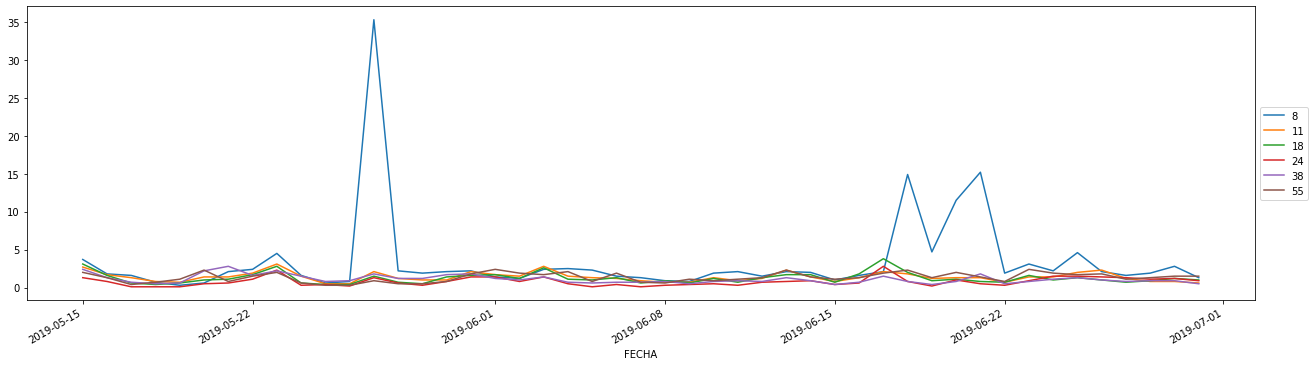

In [13]:
#magnitudes : 1  6  7  8 12  9 10 14 20 30 35 42 43 44
miClase.evolucionMagnitudRange(20, '2019-05-15', '2019-06-30')

# Crear una función que reciba una magnitud y genere un gráfico con las medias mensuales dentro de Madrid Central y fuera de ella.


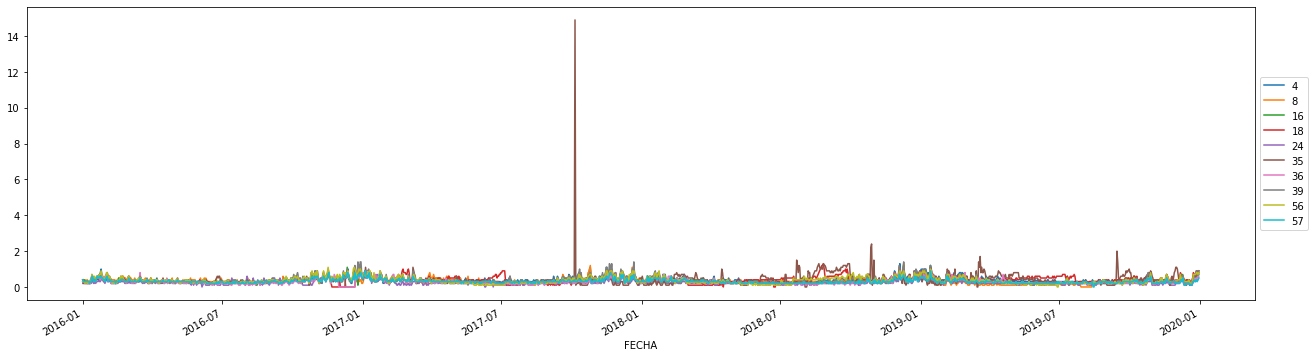

In [14]:
miClase.evolucionMagnitud(6)